### EGOR ZAITSEV - 07 452 541

### XIAOXU YAO - 07 498 897

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin, minimize, Bounds, NonlinearConstraint
from scipy import interpolate

## Exercise 1: Consumption Savings Problem

Consider the following life-cycle Problem

$$\begin{aligned}&\max_{\{c_t\}_{t=0}^{T}}\sum_{t=0}^{T}\beta^tu(c_t)\\\text{s.t.}&u(c_t)=\frac{c_t^{1-\theta}-1}{1-\theta}\\&c_t+a_{t+1}=a_t(1+r)+w_t\\&a_0\text{ given and }a_{T+1}\ge0\end{aligned}$$

### Characterize the analytical solution for any $\beta,r,w_t$

#### Euler equation
Start off by writing out the objective up to the second element

$$\max_{\{c_t\}_{t=0}^{T}}u(c_0)+\beta u(c_1)+\dots$$

At the optimum, for any two arbitrary periods it must hold that

$$\frac{\partial u(\cdot)}{\partial c_0}=\beta\frac{\partial u(\cdot)}{\partial c_1}\frac{\partial c_1}{\partial c_0}$$

Using the budget constraint we may find that $\frac{\partial c_1}{\partial c_0}=1+r$ hence the Euler equation for period $t$ reads

$$c_t^{-\theta}=\beta(1+r)c_{t+1}^{-\theta}\iff\frac{c_{t+1}}{c_t}=[\beta(1+r)]^{\frac{1}{\theta}}$$

To express consumption explicitly we must solve the Bellman equation via backwardation

$$\nu_{T}(a_{T})=\max_{a_{T+1}}\biggr\{\frac{(w_T+(1+r)a_T-a_{T+1})^{1-\theta}-1}{1-\theta}+\nu_{T+1}(a_{T+1})\biggr\}$$

Which is obviously maximized if $a_{T+1}=0$ which leads us to $\nu_T(a_T)=\frac{(w_T+(1+r)a_T)^{1-\theta}-1}{1-\theta}$. Iterating backwards leads to an explicit form of the policy function $a_{T-t+1}(a_{T-t}$. Using this and the budget constraint we may solve for the consumption function $c_{t}$

#### $\beta$-dependence
As $\beta$ increases, the consumption path is skewed towards the early life which means the consumer consumes more income early. Equivalently, lower values of $\beta$ imply lower consumption levels early in life and higher consumption levels later in life. $\beta$ parameter is thus a time preference and a tradeoff between wealth allocation and wealth spending

#### $r$-dependence
Higher interest rates imply higher returns on capital. Sufficiently high interest rates make consumption path skew towards end life

#### $w_t$-dependence
Higher levels of income imply higher levels of consumption, and vice versa

### Compute the numerical solutions setting $w_0=10, a_0=0$ and $w_t=0$ for $t\ge1, \beta=0.99,r=0.05$ and any $\theta$

In [74]:
# PARAMETERS
theta = 3
beta = 0.99
r = 0.05

# LIFE LENGTH
T = 10

# ENDOWMENT
w = [0.0] * T
w[0] = 10.
w = np.array(w)

# SAVINGS
a = [5] * (T-1)
a = a + [0]
a = np.array(a)

In [69]:
def crra(c, theta, tol=1e-5):
    """
    CRRA utility function (constant risk aversion).

    Arguments:
        c - consumption vector
        theta - risk aversion parameter
        tol - death tolerance

    Returns:
        function value
    """
    if theta != 0:
        if c < tol:
            u = -tol**(-1)
        else:
            u = (c**(1-theta) - 1)/(1-theta)
    else:
        return 'theta cannot be zero'
    
    return u


In [70]:
def budgetConstraint(a, w, r, T):
    """
    Budget constraint solved for consumption.

    Arguments:
        a - savings vector
        w - income vector
        r - interest rate
        T - agent's life length

    Returns:
        consumption vector assuming the constraint is binding
    """

    c = [0] * (T)
    c[0] = w[0] - a[0]
    for t in range(1, T-1):
        c[t] = w[t] + (1+r)*a[t-1] - a[t]
    c[T-1] = w[T-1] + (1+r)*a[T-2]

    return np.array(c)


In [71]:
def bellman(a, w, r, T, budgetConstraint, u, theta, beta):
    """
    Backward induction on the Bellman equation. Finite-horizon problems are solved via backwardation.

    Arguments:
        a - savings vector
        w - income vector
        r - interest rate
        T - agent's life length
        budgetConstraint - transform function
        u - utility function
        theta - relative risk aversion parameter
        beta - time preference parameter
    Returns:
        function value
    """
    c = budgetConstraint(a, w, r, T)
    v = u(c[-1], theta)

    for period in reversed(range(len(c) - 1)):
        v = u(c[period], theta) + beta*v
    
    return -v # return negative Bellman because we use minimizers

In [75]:
a1 = fmin(bellman, x0=a, args=(w, r, T, budgetConstraint, crra, theta, beta), maxiter=10e4)
c1 = budgetConstraint(a1, w, r, T)

Optimization terminated successfully.
         Current function value: -1.650965
         Iterations: 1417
         Function evaluations: 2022


In [76]:
data = {'w': w, 'a0': a, 'a*': a1, 'c*': c1}
df = pd.DataFrame(data)
print('numerical solution for T=10 and theta=3\n{}'.format(df.round(2)))

numerical solution for T=10 and theta=3
      w  a0    a*    c*
0  10.0   5  8.83  1.17
1   0.0   5  8.09  1.18
2   0.0   5  7.29  1.20
3   0.0   5  6.44  1.22
4   0.0   5  5.53  1.23
5   0.0   5  4.56  1.25
6   0.0   5  3.53  1.26
7   0.0   5  2.43  1.28
8   0.0   5  1.25  1.30
9   0.0   0 -0.06  1.31


To solve the Bellman equation we use simplex method (aka Nelder-Mead algorithm) which helps us minimize the objective without specifying neither first nor second derivative of the objective

Note that the vectors $\mathbf a_0$ and $\mathbf a^*$ are shifted in time by one increment. Using such a structure for the budget constraint we impose $a_0=0$ and $a_{T+1}\ge0$. We see that $a^*_{T+1}$ is slightly below zero which is a sign of truncation error of this numerical method

### How do you deal with the constraint $c_t>0$ for all $t$?

We introduce 'death tolerance' which is a number slightly above zero ($10e-5$, to be precise). If the algorithm decides to choose a consumption level below the tolerance we 'penalize' it by assigning a very negative value to consumption utility ($10e5$, an inverse of death penalty). Hence, an algorithm never chooses consumption levels close to zero

## Exercise 2: The Consumption-Savings Problem with Human Capital

Consider a two period $t=\{1,2\}$ consumption-savings problem with human capital

 - $c_t,k_t,h_t$ are consumption, stock of physical and human capital

 - $i_k,i_h$ are investment in physical and human capital

 - $\delta_k,\delta_h\in[0,1]$ are depreciation rates for physical and human capital

 - $k_2=(1-\delta_k)k_1+i_k$ and $h_2=[(1-\delta_h)h_1+i_h]^\mu$

 - $k_2\ge0$ is a borrowing constraint on physical capital

- $i_h\ge0$ is an irreversibiility constraint on human capital

- $r_k,r_h$ are returns on physical and human capital

- $\gamma,\beta,\mu$ are risk aversion, discount factor and decreasing marginal returns to human capital investment

where optimization problem is given by

$$\begin{aligned}&\max_{c_1,c_2,i_k,i_h}\biggr\{\frac{c_1^{1-\gamma}-1}{1-\gamma}+\beta\frac{c_2^{1-\gamma}-1}{1-\gamma}\biggr\}\\\text{s.t.}&(1-\delta_k)k_1+i_k\ge0\\&i_h\ge0\\&c_1+i_k+i_h-(r_kk_1+r_hh_1)=0\\&c_2-\{(1+r_k)[(1-\delta_k)k_1+i_k]+r_h[(1-\delta_h)h_1+i_h]^\mu\}=0\end{aligned}$$

### Derive the Kuhn-Tucker conditions of this optimization problem

Note first that

$$\begin{aligned}c_1&=r_kk_1+r_hh_1-i_k-i_h\\c_2&=(1+r_k)[(1-\delta_k)k_1+i_k]-r_h[(1-\delta_h)h_1+i_h]^\mu\end{aligned}$$

and write out the Lagrangian $\mathcal L(\cdot)$

$$\mathcal L(\cdot)=\frac{c_1^{1-\gamma}-1}{1-\gamma}+\beta\frac{c_2^{1-\gamma}-1}{1-\gamma}+\lambda_1[(1-\delta_k)k_1+i_k]+\lambda_2i_h\to\max_{\circ}$$

KKT conditions are then given by

$$\frac{\partial \mathcal L(\cdot)}{\partial c_t}=0$$

$$i_h\ge0$$

$$(1-\delta_k)k_1+i_k\ge0$$

$$\lambda_1,\lambda_2\ge0$$

$$\lambda_1[(1-\delta_k)k_1+i_k]=0$$

$$\lambda_2i_h=0$$

$$t\in\{1,2\}$$

### Use routine of your choice to solve the above problem for the following initial endowments

- $k_1=1,h_1=5$

- $k_1=1,h_1=1$

- $k_1=1,h_1=0.2$

In [2]:
gamma, beta, rk, rh, mu, dk, dh = 2.0, 0.96, 0.1, 1.4, 0.8, 0.05, 0.05
k, h = 1, 5
c0 = [1, 1, 1, 1]

In [4]:
def objective(c0, gamma=gamma, beta=beta):
    return (-1)*((c0[0]**(1-gamma)-1)/(1-gamma) + beta*(c0[1]**(1-gamma)-1)/(1-gamma))

In [26]:
def ik(c0, k, dk=dk):
    """
    Inequality constraint for investment into physical capital.

    Arguments:
        c0 - initial input vector
        dk - physical capital depreciation rate
        k - physical capital starting point

    Returns:
        function value
    """
    return c0[2] + (1-dk)*k

def ih(c0):
    """
    Inequality constraint for investment into human capital.

    Arguments:
        c0 - initial input vector

    Returns:
        function value
    """
    return c0[3]

def c1(c0, k, h, rk=rk, rh=rh):
    """
    Equality constraint for consumption in period 1.

    Arguments:
        c0 - initial input vector
        k - physical capital starting point
        h - human capital starting point
        rk - return on physical capital
        rh - return on human capital
        
    """
    return c0[0] + c0[2] + c0[3] - (rk*k + rh*h)

def c2(c0, k, h, rk=rk, dk=dk, rh=rh, dh=dh, mu=mu):
    """
    Equality constraint for consumption in period 2.

    Arguments:
        c0 - initial input vector
        k - physical capital starting point
        h - human capital starting point
        rk - return on physical capital
        dk - physical capital depreciation rate
        dh - human capital depreciation rate
        rh - return on human capital
        mu - decreasing marginal returns on human capital
        
    """
    return c0[1] - ((1+rk)*((1-dk)*k+c0[2]) + rh*((1-dh)*h+c0[3])**mu)


In [27]:
khs = [[1, 5], [1,1], [1, 0.2]]
for kh in khs:
    k, h = kh[0], kh[1]
    argk = (k,)
    argkh = (k, h,)

    con1 = {'type': 'ineq', 'fun': ik, 'args': argk}
    con2 = {'type': 'ineq', 'fun': ih}
    con3 = {'type': 'eq', 'fun': c1, 'args': argkh}
    con4 = {'type': 'eq', 'fun': c2, 'args': argkh}
    cons = [con1, con2, con3, con4]

    sol = minimize(objective, c0, constraints=cons, method='SLSQP')

    print('INITIAL k-h BUNDLE ({:.2f}, {:.2f}) | optimal choice bundle is\nconsumption bundle ({:.2f},{:.2f})\ninvestment bundle ({:.2f}, {:.2f})'.format(k, h, sol.x[0], sol.x[1], sol.x[2], sol.x[3]))
    if ik(sol.x, k) == 0:
        print('investment into physical is binding')
    else:
        print('investment into physical capital is not binding')    

    if ih(sol.x) <= 0:
        print('investment into human capital is binding\n')
    else:
        print('investment into human capital is not binding\n')

INITIAL k-h BUNDLE (1.00, 5.00) | optimal choice bundle is
consumption bundle (6.45,6.63)
investment bundle (0.65, -0.00)
investment into physical capital is not binding
investment into human capital is binding

INITIAL k-h BUNDLE (1.00, 1.00) | optimal choice bundle is
consumption bundle (1.90,1.95)
investment bundle (-0.54, 0.14)
investment into physical capital is not binding
investment into human capital is not binding

INITIAL k-h BUNDLE (1.00, 0.20) | optimal choice bundle is
consumption bundle (0.89,0.97)
investment bundle (-0.95, 0.44)
investment into physical is binding
investment into human capital is not binding



## Exercise 3: Interpolation of Simple Function

Interpolate the function

$$f(x)=\frac{1}{1+25x^2}$$

on $x\in[-1, 1]$ using Chebychev polynomials for $n$ equidistant nodes. Increase $n$ from 5 to 15 and plot the residuals by comparing the solution with the solution for some large $n$. What do you find? Repear the exercise using Chebychev nodes. What do you find? Repeat the exercise using splines with equidistant points. What do you find?

In [233]:
space = np.linspace(-1, 1, 200)
ns = range(5, 16)
degree = 2

def f(x):
    return (1)/(1+25*x**2)

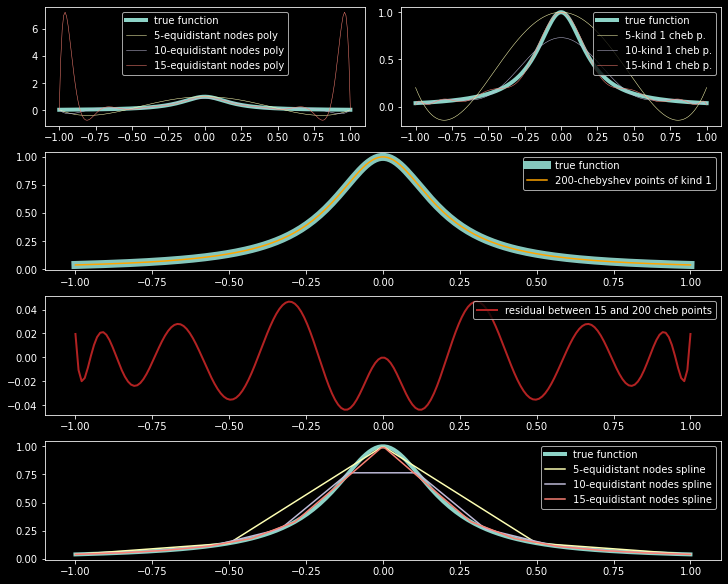

In [238]:
fig = plt.figure(constrained_layout=True, figsize=(10, 8))
gs = fig.add_gridspec(nrows=4, ncols=2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
ax5 = fig.add_subplot(gs[3, :])

ax1.plot(space, f(space), label='true function', linewidth = 4)
ax2.plot(space, f(space), label='true function', linewidth = 4)
ax3.plot(space, f(space), label='true function', linewidth = 8, alpha=0.95)
ax5.plot(space, f(space), label='true function', linewidth = 4)

for n in ns:
    nodes = np.linspace(xmin, xmax, n)
    chebroots = np.polynomial.chebyshev.chebpts1(n)
    approxn = interpolate.BarycentricInterpolator(nodes, f(nodes))
    approxc = interpolate.BarycentricInterpolator(chebroots, f(chebroots))
    t, c, k = interpolate.splrep(nodes, f(nodes), s=0, k=1)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)

    if n in [5, 10, 15]:
        ax1.plot(space, approxn(space), label=str(n)+'-equidistant nodes poly', linewidth=0.5)
        ax1.legend()
        ax2.plot(space, approxc(space), label=str(n)+'-kind 1 cheb p.', linewidth=0.5)
        ax2.legend()
        ax5.plot(space, spline(space), label=str(n)+'-equidistant nodes spline')
        ax5.legend()

# approximating for some large n with chebyshev points
N = 200
chebrootsN = np.polynomial.chebyshev.chebpts1(N)
approx = interpolate.BarycentricInterpolator(chebrootsN, f(chebrootsN))

ax3.plot(space, approx(space), label=str(N)+'-chebyshev points of kind 1', color='orange')
ax3.legend()

ax4.plot(space, approx(space) - approxc(space), label='residual between 15 and 200 cheb points', linewidth=2, color='firebrick')
ax4.legend()

We see that increasing the number of equidistant points does not necessarily lead to a better approximation using polynomial interpolation. As seen on graph 1, increasing equidistant points to 15 leads to approximation spikes on the tails of the true function

However, increasing number of Chebyshev points instead of equidistant points leads to a better function approximation using polynomial interpolation. As seen on graph 2 the red line no longer has spikes. A significant increase in the number of Chebyshev points leads to a **very close** approximation of the true function - a result which is seen on graph 3

Graph 4 depicts residuals between 15-chebyshev point approximation and 200-chebyshev point approximation which is an oscillating function. The nature of this function comes from the fact that we use polynomial interpolation. By having $n=15\to N=200$ the oscillation power should gradually dumpen to 0

With linear spline interpolation (Graph 5) it is clear that increasing the number of equidistant points leads to a better approximation of the true function. The curvature of the spline interpolation may be adjusted by tweaking the $k$ parameter

## Exercise 4: A Simple Portfolio Choice Problem

The household has initial endowment of wealth $w_0$ and $w_1=w_0(1+r^p)$ is the terminal wealth for some risk return $r^p$. This portfolio return depends on the investment in one risky and one risk-free asset and may be written as

$$r^p=\alpha^fr^f+ar$$

where $r$ is the return on the risky asset. We assume that the share invested in the risky asset, $\alpha$, is constrained

$$\underline{\alpha}\le\alpha\le\overline{\alpha}$$

We assume there are only two possible realizations of the return on the risky asset, $r_\text{low}$ and $r_\text{high}$ with assigned probabilities $p$ and $1-p$
___
The objective function is given by $\mathbb Eu(w_1)$ where

$$u(w_1)=\frac{1}{1-\gamma}w_1^{1-\gamma}$$

The portfolio shares $\alpha^f$ and $\alpha$ must satisfy

$$\alpha^f+\alpha=1$$

The portfolio return is

$$r^p=r^f+\alpha(r-r^f)\quad w_1=w_0(1+r^p)$$

The maximization problem is

$$\begin{aligned}&\max_{\alpha}\mathbb E\biggr[\frac{1}{\phi}(w_0(1+r^f+\alpha(r-r^f)))^\phi\biggr]\\\text{s.t. }&\underline{\alpha}\le\alpha\le\overline{\alpha}\end{aligned}$$

for $\phi=1-\gamma$

The givens are

$$r^f=0.02,r_\text{low}=-0.08, r_\text{high}=0.12$$

### Is the problem convex? If so, what does this imply for the solution method?

Yes, the problem is convex. Convexity of the problem implies that we may use minimization algorithms to solve for the maximum of this problem

### Assume $\underline{\alpha}=\infty_-$ and $\overline{\alpha}=\infty_+$

#### Show that the optimal portfolio share is independent of initial wealth

Too see this, imagine the return on the risky asset is certain and start by derivating the maximizer wrt $\alpha$

$$M\equiv\max_{\alpha}\biggr[\frac{1}{\phi}(w_0(1+r^f+\alpha(r-r^f)))^\phi\biggr]$$

$$\text{FOC}_\alpha\colon\frac{\phi}{\phi}(w_0(1+r^f+ar-ar^f)^{\phi-1}\cdot w_0(r-r^f)$$

This leads to

$$w_0(1+r^f)=w_0(ar^f-ar)$$

and thus

$$\alpha^*=\frac{1+r^f}{r^f-r}$$

The independce of the share allocation wrt wealth also holds in the stochastic setup as per Samuelson theorem (1969) and is given by

$$\alpha^*=(1+r^f)\frac{p\mathbb E[r] + (1-p)\mathbb E[r]}{p\mathbb E^\phi[r] + (1-p)\mathbb E^\phi[r]}$$

which follows from maximizing the following objective

$$M\equiv\max_{\alpha}\biggr\{\frac{1}{\phi}\biggr(p\bigr[w_0(1+r^f+\mathbb E[r])\bigr]^\phi+(1-p)\bigr[w_0(1+r^f+\mathbb E[r])\bigr]^\phi\biggr)\biggr\}$$

#### Solve the problem again for $\phi=-3,p=0.1$ and plot $\alpha$ against the value of the objective function on the interval $[\alpha^*-1,\alpha^*+1]$. Provide an interpretation

In [143]:
rf, rlow, rhigh = 0.02, -0.08, 0.12
phi, p = -3, 0.1
Er = p*rlow + (1-p)*rhigh # expected return on risky asset
r = np.array([rf - Er, rf + Er]) # return grid
proba = np.array([p, 1-p]) # P(rlow) and P(rhigh)
excess = r - rf # excess return

def objective(a, rf=rf, r=r, phi=phi, proba=proba, excess=excess, w0=1):
    """
    Objective function in vector form.
    """
    M = 1/phi*np.dot(proba.T, np.power(w0*(1+rf+a*excess), phi))
    return (-1)*M

In [162]:
alphanum = fmin(objective, x0=1)
print('Objective-minimining alpha is {:.2f}'.format(alphanum[0].round(2)))


Optimization terminated successfully.
         Current function value: 0.218748
         Iterations: 18
         Function evaluations: 36
Objective-minimining alpha is 2.73


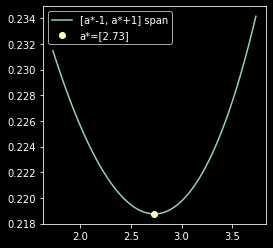

In [163]:
alphax = np.linspace(alphanum-1,alphanum+1, 100)
alphay = [objective(alpha) for alpha in alphax]
plt.figure(figsize=(4, 4))
plt.plot(alphax, alphay, label='[a*-1, a*+1] span')
plt.plot(alphanum, objective(alphanum), 'o', label='a*='+str(alphanum.round(2)))
plt.legend()

### Now consider the constrained optimization problem with $\underline{\alpha}=0$ and $\overline{\alpha}=1$

#### Calculate the solution for $\phi=-3,p=0.1$

In [164]:
def con1(a):
    return a
def con2(a):
    return 1 - a

con1 = {'type': 'ineq', 'fun': con1}
con2 = {'type': 'ineq', 'fun': con2}
cons = [con1, con2]

alphanumb = minimize(objective, x0=0, constraints=cons)
print('Objective-minimining alpha is {:.2f} in [0, 1]'.format(alphanumb.x[0].round(2)))

Objective-minimining alpha is 1.00 in [0, 1]


#### Compare your results interpret

In an unconstrained (unbounded) problem the global minimum of the function is found which is approximatly 2.73. When we impose bounds on the search corridor up until 1, we do not allow the algorithm to descent (climb) above the upper bound. The upper bound is the lowest (highest) point such that the objective is minimized (maximized) in the given subdomain (look at graph below)

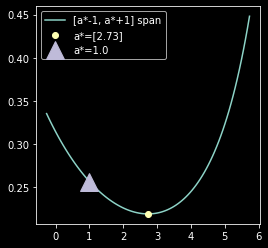

In [174]:
alphax = np.linspace(alphanum-3,alphanum+3, 100)
alphay = [objective(alpha) for alpha in alphax]
plt.figure(figsize=(4, 4))
plt.plot(alphax, alphay, label='[a*-1, a*+1] span')
plt.plot(alphanum, objective(alphanum), 'o', label='a*='+str(alphanum.round(2)))
plt.plot(alphanumb.x[0], objective(alphanumb.x[0]), '^', markersize=18, label='a*='+str(alphanumb.x[0].round(2)))
plt.legend()